#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [1]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [2]:
# loading nasdaq-100 stock data

stock_data = qndata.stocks.load_spx_data(tail = 365 * 5, assets =["NYS:ABBV", "NYS:ABT", "NYS:ACN", "NYS:ADM", "NYS:AFL", "NYS:AIG", "NYS:ALL", "NYS:AMT", "NYS:APD", "NYS:APH", "NYS:ARE", "NYS:AVB", "NYS:AXP", "NYS:BA", "NYS:BAC", "NYS:BDX", "NYS:BLK", "NYS:CCI", "NYS:CL", "NYS:CVX"])
#I selected these stocks because many of these companies have a proven track record of stable revenues and earnings, making them relatively safe investments.
#They also span different sectors which helps mitigate industry-specific risks.
#Companies are also in sectors with strong future growth prospects, which could offer high returns.


100% (1610960 of 1610960) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/1 0s
Data loaded 0s


In [3]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price.
       These features can be modified and new ones can be added easily.
    """

    # trend:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)

    # moving average convergence  divergence (MACD):
    macd = qnta.macd(data.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)

    # volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14)

    # the stochastic oscillator:
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)

    # the relative strength index:
    rsi = qnta.rsi(data.sel(field="close"))

    # the logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0) # fill NaN
    price = np.log(price)

    #The TRIX (Triple Exponential Average) indicator is useful in trading algorithms because it helps smooth out price movements, reducing market noise,
    #and highlighting the underlying trend. It is a momentum oscillator that shows the percentage rate of change of a triple exponentially smoothed 
    #moving average.
    vol = data.sel(field="vol")
    liq = data.sel(field="is_liquid")
    close = data.sel(field="close")
    high = data.sel(field="high")
    low = data.sel(field="low")
    trix = qnta.trix(data.sel(field='high'), 30)

    # combine the six features:
    result = xr.concat(
        [trend, macd2_signal.sel(field="close"), volatility,  d, rsi, price],
        pd.Index(
            ["trend",  "macd", "stochastic_d", "rsi", "price", "trix"],
            name = "field"
        )
    )

    return result.transpose("time", "field", "asset")

In [4]:
# displaying the features:
my_features = get_features(stock_data)
display(my_features.sel(field="trend").to_pandas())

asset,NYS:ABBV,NYS:ABT,NYS:ACN,NYS:ADM,NYS:AFL,NYS:AIG,NYS:ALL,NYS:AMT,NYS:APD,NYS:APH,NYS:ARE,NYS:AVB,NYS:AXP,NYS:BA,NYS:BAC,NYS:BDX,NYS:BLK,NYS:CCI,NYS:CL,NYS:CVX
time,,,,,,,,,,,,,,,,,,,,
2020-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-06,-0.046213,-0.076240,-0.078023,-0.243184,-0.203276,-0.123360,-0.147696,-0.399860,-0.333492,0.019798,-0.342940,-0.192422,0.138956,0.264304,0.068829,0.009885,-0.028956,-0.480776,-0.253140,-0.126300
2025-01-07,-0.052208,-0.064663,-0.029677,-0.248662,-0.166584,-0.115908,-0.146015,-0.441724,-0.296442,0.030172,-0.347005,-0.213962,0.134687,0.291290,0.111865,0.032636,-0.133549,-0.506242,-0.251168,-0.075472
2025-01-08,-0.066597,-0.039425,-0.016705,-0.215167,-0.139826,-0.164438,-0.049604,-0.398488,-0.303792,0.041826,-0.337965,-0.196423,0.137874,0.266694,0.113783,0.066362,-0.118078,-0.494996,-0.242369,-0.059872


In [5]:
def get_target_classes(data):
    """ Target classes for predicting if price goes up or down."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_positive = 1 # prices goes up
    class_negative = 0 # price goes down

    target_price_up = xr.where(price_future > price_current, class_positive, class_negative)

    return target_price_up

In [6]:
# displaying the target classes:
my_targetclass = get_target_classes(stock_data)
display(my_targetclass.to_pandas())

asset,NYS:ABBV,NYS:ABT,NYS:ACN,NYS:ADM,NYS:AFL,NYS:AIG,NYS:ALL,NYS:AMT,NYS:APD,NYS:APH,NYS:ARE,NYS:AVB,NYS:AXP,NYS:BA,NYS:BAC,NYS:BDX,NYS:BLK,NYS:CCI,NYS:CL,NYS:CVX
time,,,,,,,,,,,,,,,,,,,,
2020-01-17,0,1,0,0,0,0,1,1,1,0,1,1,0,0,0,1,0,1,1,0
2020-01-21,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,1,1,1,0,0
2020-01-22,0,0,1,1,1,0,1,1,0,0,1,1,0,1,0,0,1,1,1,1
2020-01-23,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,0,1,0,0
2020-01-24,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-06,0,1,1,0,1,1,1,0,1,1,0,0,1,1,1,1,0,0,0,1
2025-01-07,0,1,1,1,1,0,1,1,0,1,1,1,1,0,1,1,1,1,1,1
2025-01-08,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1


In [7]:
def get_model():
    """
The Ridge regression model stands out as an excellent option, as it effectively tackles multicollinearity by incorporating an L2 regularization term. 
This addition not only helps prevent overfitting but also enhances the model's ability to generalize in datasets featuring highly correlated variables.
    """

    model = linear_model.Ridge(alpha=.5)
    return model

In [8]:
# Create and train the models working on an asset-by-asset basis.

asset_name_all = stock_data.coords["asset"].values

models = dict()

for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = my_targetclass.sel(asset=asset_name).dropna("time", "any")
        features_cur = my_features.sel(asset=asset_name).dropna("time", "any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

print(models)

{'NYS:ABBV': Ridge(alpha=0.5), 'NYS:ABT': Ridge(alpha=0.5), 'NYS:ACN': Ridge(alpha=0.5), 'NYS:ADM': Ridge(alpha=0.5), 'NYS:AFL': Ridge(alpha=0.5), 'NYS:AIG': Ridge(alpha=0.5), 'NYS:ALL': Ridge(alpha=0.5), 'NYS:AMT': Ridge(alpha=0.5), 'NYS:APD': Ridge(alpha=0.5), 'NYS:APH': Ridge(alpha=0.5), 'NYS:ARE': Ridge(alpha=0.5), 'NYS:AVB': Ridge(alpha=0.5), 'NYS:AXP': Ridge(alpha=0.5), 'NYS:BA': Ridge(alpha=0.5), 'NYS:BAC': Ridge(alpha=0.5), 'NYS:BDX': Ridge(alpha=0.5), 'NYS:BLK': Ridge(alpha=0.5), 'NYS:CCI': Ridge(alpha=0.5), 'NYS:CL': Ridge(alpha=0.5), 'NYS:CVX': Ridge(alpha=0.5)}


/tmp/ipykernel_1161/1693025377.py:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/1693025377.py:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/1693025377.py:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/1693025377.py:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/1693025377.py:10: FutureWarning:

Passing 'how' as positional argument(s) to dro

Feature: 0, Score: 0.08817
Feature: 1, Score: -0.00199
Feature: 2, Score: -0.02250
Feature: 3, Score: 0.00078
Feature: 4, Score: 0.00235
Feature: 5, Score: -0.14229


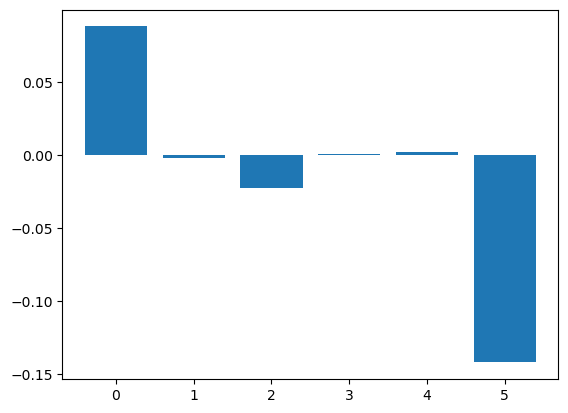

In [9]:
# Showing which features are more important in predicting:

importance = models["NYS:BLK"].coef_
importance

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [10]:
# Performs prediction and generates output weights:

asset_name_all = stock_data.coords["asset"].values
weights = xr.zeros_like(stock_data.sel(field="close"))

for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception("model prediction failed")

print(weights)

<xarray.DataArray 'stocks_s&p500' (time: 1254, asset: 20)> Size: 201kB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.46282238, 0.50209877, 0.498414  , ..., 0.45997059, 0.48143473,
        0.51811262],
       [0.47122997, 0.51135623, 0.49290758, ..., 0.44816683, 0.49600619,
        0.51543894],
       [0.50369909, 0.50606816, 0.49468767, ..., 0.4757796 , 0.4759121 ,
        0.51743789]])
Coordinates:
  * asset    (asset) <U8 640B 'NYS:ABBV' 'NYS:ABT' ... 'NYS:CL' 'NYS:CVX'
  * time     (time) datetime64[ns] 10kB 2020-01-17 2020-01-21 ... 2025-01-13
    field    <U5 20B 'close'


/tmp/ipykernel_1161/2713452462.py:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/2713452462.py:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/2713452462.py:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/2713452462.py:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/2713452462.py:10: FutureWarning:

Passing 'how' as positional argument(s) to dro

In [11]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_data, weights)
sharpe

0.9256926088681587

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-06,2.021637,-0.007308,0.163577,-0.058321,-0.189564,0.928137,0.151822,1.0,20.0,0.027662,79.013401
2025-01-07,2.023714,0.001028,0.163511,-0.057354,-0.189564,0.929163,0.151929,1.0,20.0,0.027662,79.033447
2025-01-08,2.031215,0.003706,0.163452,-0.053860,-0.189564,0.933933,0.152653,1.0,20.0,0.027652,79.033616
2025-01-10,2.002539,-0.014117,0.163520,-0.067217,-0.189564,0.912701,0.149245,1.0,20.0,0.027655,79.026681
2025-01-13,2.022109,0.009772,0.163506,-0.058101,-0.189564,0.925693,0.151356,1.0,20.0,0.027662,81.797859


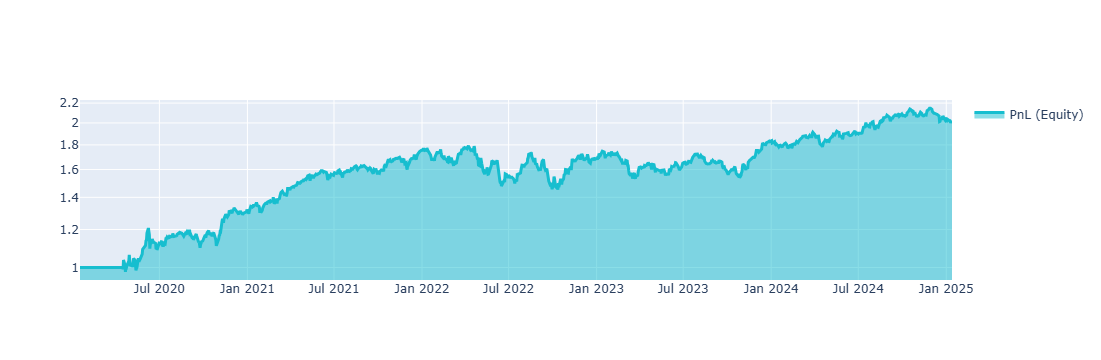

time,2025-01-13
field,
sharpe_ratio,0.925693



Ok. This strategy does not correlate with other strategies.


In [12]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_data)

In [13]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

-0.03462310869907849

In [14]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

-0.032645743507022

In [15]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

0.49407408751862947

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [16]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", "any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

    return models

In [17]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="close"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

            if len(features_cur.time) < 1:
                continue

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except:
                logging.exception("model prediction failed")

    return weights

In [18]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_nasdaq100",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

Run the last iteration...


100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (8966212 of 8966212) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/1 2s
Data loaded 2s


/tmp/ipykernel_1161/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/926670739.py:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/926670739.py:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna w

fetched chunk 1/1 2s
Data loaded 2s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write output: /root/fractions.nc.gz
State saved.
---
Run First Iteration...


100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (9037908 of 9037908) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/1 2s
Data loaded 2s


/tmp/ipykernel_1161/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/926670739.py:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/926670739.py:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna w

---
Run all iterations...
Load data...


/tmp/ipykernel_1161/3005845302.py:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/3005845302.py:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/3005845302.py:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (13011740 of 13011740) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/8 1s


100% (13011740 of 13011740) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/8 2s


100% (13011740 of 13011740) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/8 2s


100% (13011716 of 13011716) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/8 3s


100% (13011648 of 13011648) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/8 4s


100% (13011648 of 13011648) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/8 5s


100% (13011648 of 13011648) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/8 6s


100% (13011716 of 13011716) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 8/8 7s
Data loaded 7s


100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (12923652 of 12923652) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/7 1s


100% (12923648 of 12923648) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/7 1s


100% (12923648 of 12923648) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/7 2s


100% (12923624 of 12923624) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/7 3s


100% (12923544 of 12923544) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/7 4s


100% (12923544 of 12923544) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/7 4s


100% (12923624 of 12923624) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/7 5s
Data loaded 5s
Backtest...


/tmp/ipykernel_1161/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/926670739.py:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/926670739.py:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_1161/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna w

fetched chunk 1/7 1s


100% (13026208 of 13026208) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/7 1s


100% (13026208 of 13026208) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/7 2s


100% (13026184 of 13026184) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/7 3s


100% (13026104 of 13026104) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/7 4s


100% (13026104 of 13026104) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/7 4s


100% (13026184 of 13026184) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/7 5s
Data loaded 5s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write output: /root/fractions.nc.gz
State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2025-01-13
Sharpe Ratio = 0.8581597471056261
Ok.
---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Select the asset (or leave blank to display the overall stats):


interactive(children=(Combobox(value='', description='asset', options=('', 'NAS:AAL', 'NAS:AAPL', 'NAS:ABNB', …

100% (5040 of 5040) |####################| Elapsed Time: 0:03:46 Time:  0:03:46


The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.